# Lab 1 - Loan Prediction

#### Import necessary libraries




In [565]:
import math # this is needed for my custom functions


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import  LabelEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import accuracy_score


from xgboost import XGBClassifier

### Load training and validation datasets


In [566]:
train = pd.read_csv("train.csv")
test = pd.read_csv("valid.csv")

### Exploration of the training dataset

In [567]:
# Display basic information about the training dataset
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517788 entries, 0 to 517787
Columns: 145 entries, id to loan_status
dtypes: float64(106), int64(5), object(34)
memory usage: 572.8+ MB


Text(0.5, 1.0, 'Distribution of Loan Status')

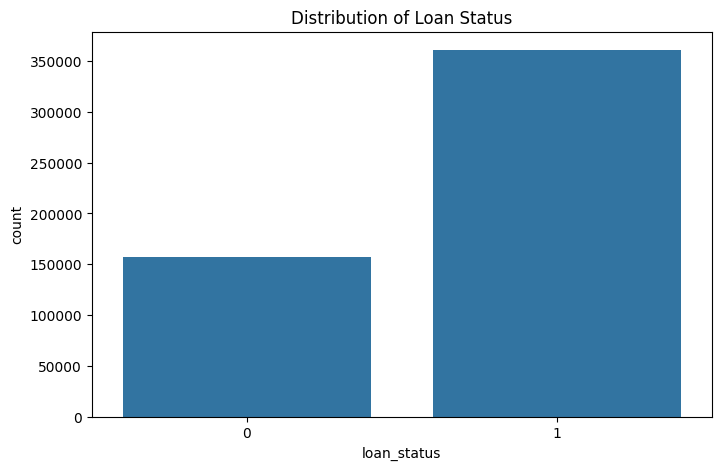

In [568]:
# Explore the target variable distribution
plt.figure(figsize=(8, 5))
sns.countplot(x='loan_status', data=train)
plt.title('Distribution of Loan Status')

In [569]:
# checking out the train dataset
train.sample(5)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term,loan_status
285821,NaN,NaN,10000,10000,10000.0,60 months,13.98,232.58,C,C3,...,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,0
238063,NaN,NaN,8000,8000,8000.0,36 months,14.47,275.26,C,C2,...,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,1
306538,NaN,NaN,11200,11200,11200.0,60 months,20.89,302.31,F,F1,...,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,0
345937,NaN,NaN,10000,10000,10000.0,60 months,18.99,259.36,D,D4,...,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,0
365621,NaN,NaN,9200,9200,9200.0,36 months,13.33,311.45,C,C3,...,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,1


In [570]:
# Explore numerical features
numeric_summary = train.describe()
print("Summary Statistics for Numerical Features:")
print(numeric_summary)

# %%
# Explore categorical features
categorical_summary = train.describe(include='object')
print("Summary Statistics for Categorical Features:")
print(categorical_summary)

Summary Statistics for Numerical Features:
        id  member_id      loan_amnt    funded_amnt  funded_amnt_inv  \
count  0.0        0.0  517788.000000  517788.000000    517788.000000   
mean   NaN        NaN   14580.588050   14572.051786     14549.171157   
std    NaN        NaN    8719.958244    8715.990085      8718.254109   
min    NaN        NaN     500.000000     500.000000         0.000000   
25%    NaN        NaN    8000.000000    8000.000000      8000.000000   
50%    NaN        NaN   12175.000000   12150.000000     12075.000000   
75%    NaN        NaN   20000.000000   20000.000000     20000.000000   
max    NaN        NaN   40000.000000   40000.000000     40000.000000   

            int_rate    installment    annual_inc  url            dti  ...  \
count  517788.000000  517788.000000  5.177880e+05  0.0  517656.000000  ...   
mean       13.580725     442.133178  7.534984e+04  NaN      18.516001  ...   
std         4.856040     261.527582  6.797839e+04  NaN      11.408157  ...

### Checking for missing values in the training dataset

In [571]:
# number of null values in each column as a percentage of the total number of rows
train.isna().sum() * 100 / len(train)

id                       100.000000
member_id                100.000000
loan_amnt                  0.000000
funded_amnt                0.000000
funded_amnt_inv            0.000000
                            ...    
settlement_date           96.280331
settlement_amount         96.280331
settlement_percentage     96.280331
settlement_term           96.280331
loan_status                0.000000
Length: 145, dtype: float64

### Drop irrelevant columns and columns with majority of null values  from training and validation datasets
* After this step we will have about 517788 entries and 67 columns which is much better than the original 😊😊😊


In [572]:
columns_to_drop  = ["id","member_id","grade","emp_title","issue_d","pymnt_plan","url","desc","title","mths_since_last_record",
                      "out_prncp","out_prncp_inv","total_rec_late_fee","recoveries","collection_recovery_fee","next_pymnt_d",
                      "last_credit_pull_d","mths_since_last_major_derog","policy_code","annual_inc_joint","dti_joint",
                      "verification_status_joint","acc_now_delinq","tot_coll_amt","open_acc_6m","open_act_il","open_il_12m",
                      "open_il_24m","mths_since_rcnt_il","total_bal_il","il_util","open_rv_12m","open_rv_24m","max_bal_bc",
                      "all_util","inq_fi","total_cu_tl","inq_last_12m","chargeoff_within_12_mths","delinq_amnt","mths_since_recent_bc_dlq",
                      "mths_since_recent_revol_delinq","num_tl_120dpd_2m","num_tl_30dpd","num_tl_90g_dpd_24m","revol_bal_joint",
                      "sec_app_earliest_cr_line","sec_app_inq_last_6mths","sec_app_mort_acc","sec_app_open_acc","sec_app_revol_util",
                      "sec_app_open_act_il","sec_app_num_rev_accts","sec_app_chargeoff_within_12_mths","sec_app_collections_12_mths_ex_med",
                      "sec_app_mths_since_last_major_derog","hardship_flag","hardship_type","hardship_reason","hardship_status",
                      "deferral_term","hardship_amount","hardship_start_date","hardship_end_date","payment_plan_start_date","hardship_length",
                      "hardship_dpd","hardship_loan_status","orig_projected_additional_accrued_interest","hardship_payoff_balance_amount",
                      "hardship_last_payment_amount","disbursement_method","debt_settlement_flag_date","settlement_status","settlement_date",
                      "settlement_amount","settlement_percentage","settlement_term"]

In [573]:
train.drop(columns=columns_to_drop, inplace=True)
test.drop(columns=columns_to_drop, inplace=True)

In [574]:
train.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,sub_grade,emp_length,home_ownership,annual_inc,...,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,debt_settlement_flag,loan_status
0,14000,14000,14000.0,36 months,7.35,434.53,A4,1 year,MORTGAGE,44000.0,...,100.0,0.0,0.0,1.0,67943.0,23659.0,13600.0,48043.0,N,1
1,2000,2000,2000.0,36 months,16.29,70.61,D2,NaN,MORTGAGE,11420.0,...,93.7,100.0,1.0,0.0,9800.0,4168.0,1300.0,0.0,N,1
2,5000,5000,4750.0,36 months,7.39,155.28,A4,4 years,MORTGAGE,65000.0,...,100.0,0.0,0.0,0.0,237800.0,20061.0,64200.0,21600.0,N,1
3,20600,20600,20600.0,36 months,11.99,684.12,B5,NaN,MORTGAGE,46956.0,...,91.2,50.0,0.0,0.0,105100.0,12355.0,15300.0,0.0,N,1
4,10000,10000,10000.0,36 months,7.39,310.56,A4,< 1 year,MORTGAGE,115000.0,...,97.0,25.0,0.0,1.0,135735.0,141874.0,12000.0,123535.0,N,1


In [575]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517788 entries, 0 to 517787
Data columns (total 67 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   loan_amnt                   517788 non-null  int64  
 1   funded_amnt                 517788 non-null  int64  
 2   funded_amnt_inv             517788 non-null  float64
 3   term                        517788 non-null  object 
 4   int_rate                    517788 non-null  float64
 5   installment                 517788 non-null  float64
 6   sub_grade                   517788 non-null  object 
 7   emp_length                  486488 non-null  object 
 8   home_ownership              517788 non-null  object 
 9   annual_inc                  517788 non-null  float64
 10  verification_status         517788 non-null  object 
 11  purpose                     517788 non-null  object 
 12  zip_code                    517787 non-null  object 
 13  addr_state    

###  Separate features and target variable from training and validation datasets


In [576]:
target_column = 'loan_status'

X = train.drop(columns=[target_column])
X_valid = test.drop(columns=[target_column])

y = train[target_column]
y_valid = test[target_column]


In [577]:
X.shape

(517788, 66)

# Separate numeric and categorical columns
* Because ML models can only work with numerical data

In [578]:
numeric_cols = X.select_dtypes(include='number').columns
categorical_cols = X.select_dtypes(include='object').columns

# Display unique values and their counts for each categorical column
for column in categorical_cols:
    unique_counts = X[column].value_counts()
    print(f"{column}:\n{unique_counts}\n")


term:
term
36 months    382494
60 months    135294
Name: count, dtype: int64

sub_grade:
sub_grade
C1    32738
B4    31023
B5    30847
C2    30672
B3    30120
C4    29370
C3    29200
B2    27076
C5    26874
B1    25489
A5    23063
D1    20862
D2    18299
A4    18273
D3    16053
D4    14874
A1    14602
A3    13175
A2    12741
D5    12650
E1    10140
E2     9329
E3     8034
E4     6978
E5     6446
F1     4488
F2     3290
F3     2804
F4     2223
F5     1814
G1     1379
G2      988
G3      742
G4      600
G5      532
Name: count, dtype: int64

emp_length:
emp_length
10+ years    169173
2 years       46993
< 1 year      41689
3 years       41332
1 year        33849
5 years       32308
4 years       31137
6 years       24144
8 years       23348
7 years       22838
9 years       19677
Name: count, dtype: int64

home_ownership:
home_ownership
MORTGAGE    252366
RENT        209867
OWN          55379
ANY            104
OTHER           56
NONE            16
Name: count, dtype: int64

verification

###  Defining and applying the functions for feature transformations


In [579]:

#Extract the numeric part from the term column
def extract_term_in_months(term):
    return int(term.split()[0])

In [580]:
X["term"] = X["term"].apply(extract_term_in_months)
X_valid["term"] = X_valid["term"].apply(extract_term_in_months)






In [581]:
X['term'].dtype  # This gave me the data type of the term column as int64, which means it was successfully converted to an integer

dtype('int64')

In [582]:
#     Map employment length to an ordinal value.
def employment_length_to_ordinal(emp_length):
    
    if isinstance(emp_length, str):
        ordinal_mapping = {'< 1 year': 0, '1 year': 1, '2 years': 2, '3 years': 3, '4 years': 4,
                           '5 years': 5, '6 years': 6, '7 years': 7, '8 years': 8, '9 years': 9, '10+ years': 10}
        return ordinal_mapping.get(emp_length, None)
    else:
        return None

In [583]:
X["emp_length"] = X["emp_length"].apply(employment_length_to_ordinal)
X_valid["emp_length"] = X_valid["emp_length"].apply(employment_length_to_ordinal)

In [584]:
X["emp_length"].dtype 

dtype('float64')

In [585]:
# Convert a string containing digits to an integer

def convert_string_to_int(value):
    if isinstance(value, str):
        numeric_part = ''.join(filter(str.isdigit, value))
        return int(numeric_part)
    else:
        return None

In [586]:
X["zip_code"] = X["zip_code"].apply(convert_string_to_int)
X_valid["zip_code"] = X_valid["zip_code"].apply(convert_string_to_int)


In [587]:
X["zip_code"].dtype

dtype('float64')

In [588]:
# Convert loan grade to an encoded numerical value.
# This encoding allows to represent loan grades with both a letter and a numeric component as a single numerical value


def grade_to_encoded_value(grade):
    
    letter_part, number_part = grade[0], int(grade[1])
    letter_value = ord(letter_part) - ord('A') + 1
    encoded_value = (letter_value - 1) * 5 + number_part
    return encoded_value

In [589]:
X["sub_grade"] = X["sub_grade"].apply(grade_to_encoded_value)
X_valid["sub_grade"] = X_valid["sub_grade"].apply(grade_to_encoded_value)

In [590]:
X["sub_grade"].dtype    

dtype('int64')

###  Label encode categorical variables


In [591]:

encoder = LabelEncoder()

In [592]:
columns_to_encode = ['home_ownership', 'verification_status', 'initial_list_status', 
                     'application_type', 'debt_settlement_flag']

for column in columns_to_encode:
    X[column] = encoder.fit_transform(X[column])
    X_valid[column] = encoder.fit_transform(X_valid[column])


### One-hot encode the 'purpose' and 'addr_state' columns


In [593]:
def one_hot_encode_columns(data, columns):
    return pd.get_dummies(data, columns=columns, prefix='', prefix_sep='')

# Apply one-hot encoding to the specified columns for both X and X_valid
columns_to_one_hot_encode = ["purpose", "addr_state"]

X = one_hot_encode_columns(X, columns_to_one_hot_encode)
X_valid = one_hot_encode_columns(X_valid, columns_to_one_hot_encode)


In [594]:
X.columns   

Index(['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate',
       'installment', 'sub_grade', 'emp_length', 'home_ownership',
       'annual_inc',
       ...
       'SD', 'TN', 'TX', 'UT', 'VA', 'VT', 'WA', 'WI', 'WV', 'WY'],
      dtype='object', length=129)

In [595]:
X.shape  # As we can see, the number of columns has increased significantly after one-hot encoding

(517788, 129)

###  Encode date columns to numeric features

* The goal is to convert the specified date column to a numeric representation by extracting the year and month information from the date column and then dropping the original date column

In [596]:
# Encode date columns to numeric features
def encode_date_to_numeric(df, date_columns):
    for date_column in date_columns:
        df[date_column] = pd.to_datetime(df[date_column], format='%b-%Y')
        df[date_column+'_year'] = df[date_column].dt.year
        df[date_column+'_month'] = df[date_column].dt.month
    return df

# Apply date encoding and drop original date columns
date_columns_to_encode = ['earliest_cr_line', 'last_pymnt_d']

X = encode_date_to_numeric(X, date_columns_to_encode)
X_valid = encode_date_to_numeric(X_valid, date_columns_to_encode)

# Drop original date columns
X.drop(labels=date_columns_to_encode, axis=1, inplace=True)
X_valid.drop(labels=date_columns_to_encode, axis=1, inplace=True)


In [597]:
X.columns  # As you can see, the date columns have been encoded and the original date columns have been dropped 

Index(['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate',
       'installment', 'sub_grade', 'emp_length', 'home_ownership',
       'annual_inc',
       ...
       'VA', 'VT', 'WA', 'WI', 'WV', 'WY', 'earliest_cr_line_year',
       'earliest_cr_line_month', 'last_pymnt_d_year', 'last_pymnt_d_month'],
      dtype='object', length=131)

###  Generate correlation matrix and plot heatmap


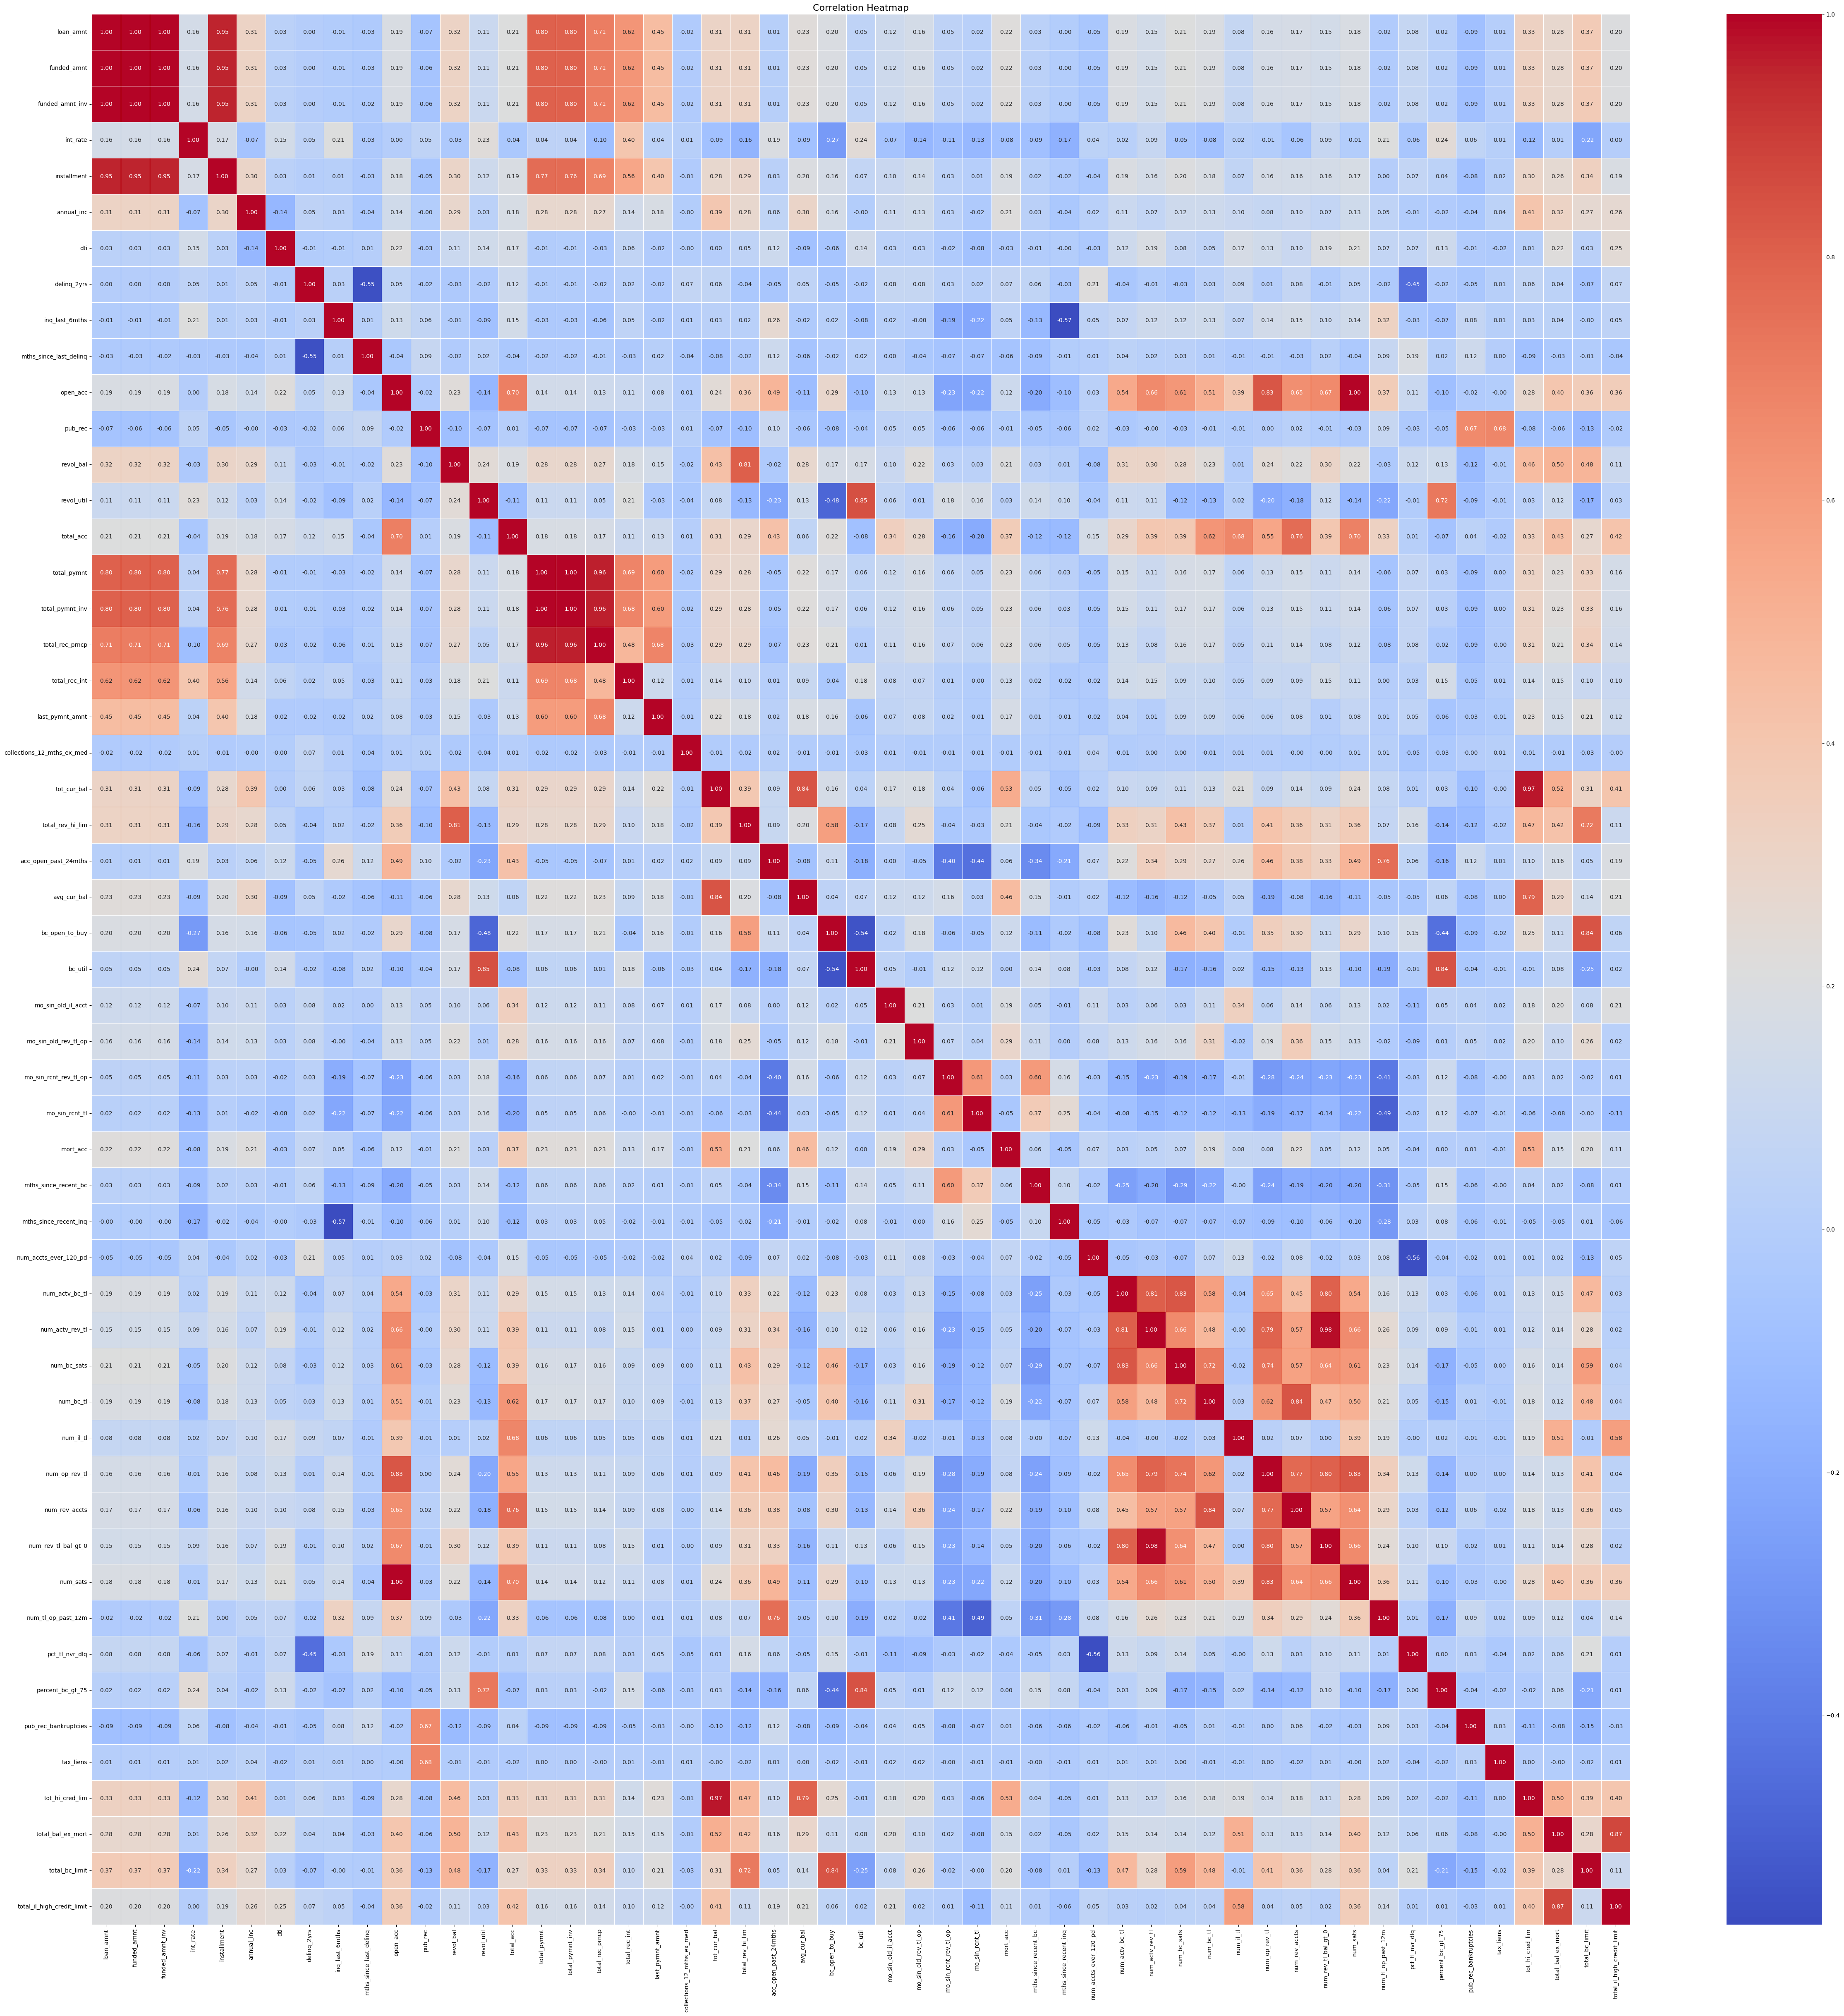

In [598]:
def plot_correlation_heatmap(data, numeric_cols):
    correlation_matrix = data[numeric_cols].corr()

    plt.figure(figsize=(60, 60))
    heatmap = sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, annot_kws={"size": 10})
    
    # Rotate the y-axis labels for better readability
    heatmap.set_yticklabels(heatmap.get_yticklabels(), rotation=0)
    
    plt.title("Correlation Heatmap", fontsize=16)
    plt.show()

plot_correlation_heatmap(X, numeric_cols)


###  Drop highly correlated features based on correlation matrix


In [599]:
columns_to_drop = ["tot_hi_cred_lim", "percent_bc_gt_75", "num_sats", "num_rev_tl_bal_gt_0", 
                   "total_rec_prncp", "total_pymnt_inv", "installment", "funded_amnt_inv", "funded_amnt"]

X.drop(columns=columns_to_drop, inplace=True)
X_valid.drop(columns=columns_to_drop, inplace=True)


### Impute missing values with mean and scale features and feature selection


In [600]:
# --- Imputation and scaling with a pipeline for conciseness ---
impute_and_scale_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', MinMaxScaler()),
])

# Apply the pipeline to both X and X_valid
X_processed = impute_and_scale_pipeline.fit_transform(X)
X_valid_processed = impute_and_scale_pipeline.transform(X_valid)  

# --- Feature selection with clear explanation ---
k_best = SelectKBest(score_func=chi2, k=20)

# Note: k=20 was determined as optimal based on prior experimentation by me 
X_selected = k_best.fit_transform(X_processed, y)



### Splitting the training dataset 

In [601]:
# --- Train-test split with concise formatting ---
X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y, test_size=0.2, random_state=0
)

### XGBClassifier model training and validation

In [602]:
model = XGBClassifier()
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [603]:
y_pred = model.predict(X_test)
X_valid_selected = k_best.transform(X_valid_processed)
y_pred_valid = model.predict(X_valid_selected)
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

0.9954904497962495


In [604]:
accuracy_valid = accuracy_score(y_valid, y_pred_valid)
print(accuracy_valid)

0.9951679065563512


### Testing the classifier model created 😍😍😍

In [605]:
df = pd.read_csv('X_test.csv')


In [606]:
df.columns

Index(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'sub_grade',
       ...
       'hardship_payoff_balance_amount', 'hardship_last_payment_amount',
       'disbursement_method', 'debt_settlement_flag',
       'debt_settlement_flag_date', 'settlement_status', 'settlement_date',
       'settlement_amount', 'settlement_percentage', 'settlement_term'],
      dtype='object', length=144)

In [607]:
"purpose" in df.columns

True

In [608]:
columns_to_drop  = ["id","member_id","grade","emp_title","issue_d","pymnt_plan","url","desc","title","mths_since_last_record",
                      "out_prncp","out_prncp_inv","total_rec_late_fee","recoveries","collection_recovery_fee","next_pymnt_d",
                      "last_credit_pull_d","mths_since_last_major_derog","policy_code","annual_inc_joint","dti_joint",
                      "verification_status_joint","acc_now_delinq","tot_coll_amt","open_acc_6m","open_act_il","open_il_12m",
                      "open_il_24m","mths_since_rcnt_il","total_bal_il","il_util","open_rv_12m","open_rv_24m","max_bal_bc",
                      "all_util","inq_fi","total_cu_tl","inq_last_12m","chargeoff_within_12_mths","delinq_amnt","mths_since_recent_bc_dlq",
                      "mths_since_recent_revol_delinq","num_tl_120dpd_2m","num_tl_30dpd","num_tl_90g_dpd_24m","revol_bal_joint",
                      "sec_app_earliest_cr_line","sec_app_inq_last_6mths","sec_app_mort_acc","sec_app_open_acc","sec_app_revol_util",
                      "sec_app_open_act_il","sec_app_num_rev_accts","sec_app_chargeoff_within_12_mths","sec_app_collections_12_mths_ex_med",
                      "sec_app_mths_since_last_major_derog","hardship_flag","hardship_type","hardship_reason","hardship_status",
                      "deferral_term","hardship_amount","hardship_start_date","hardship_end_date","payment_plan_start_date","hardship_length",
                      "hardship_dpd","hardship_loan_status","orig_projected_additional_accrued_interest","hardship_payoff_balance_amount",
                      "hardship_last_payment_amount","disbursement_method","debt_settlement_flag_date","settlement_status","settlement_date",
                      "settlement_amount","settlement_percentage","settlement_term"]

df.drop(labels=columns_to_drop, axis=1, inplace=True)



In [609]:
# Apply custom functions to specific columns

df["term"] = df["term"].apply(extract_term_in_months)
df["emp_length"] = df["emp_length"].apply(employment_length_to_ordinal)
df["sub_grade"] = df["sub_grade"].apply(grade_to_encoded_value)
df["zip_code"] = df["zip_code"].apply(convert_string_to_int)

In [610]:
# Encode categorical columns
categorical_columns_to_encode = ['home_ownership', 'verification_status', 'initial_list_status', 'application_type', 'debt_settlement_flag']
for column in categorical_columns_to_encode:
    
    df[column] = encoder.fit_transform(df[column])

In [611]:
df.drop(labels=["tot_hi_cred_lim","percent_bc_gt_75","num_sats","num_rev_tl_bal_gt_0","total_rec_prncp","total_pymnt_inv","installment",
                   "funded_amnt_inv","funded_amnt"],axis=1,inplace=True)

In [612]:
# df = pd.get_dummies(df, columns = ["purpose"],prefix = '', prefix_sep = '')
df = pd.get_dummies(df, columns = ["addr_state"],prefix = '', prefix_sep = '')


date_columns_to_encode = ['earliest_cr_line', 'last_pymnt_d']

df = encode_date_to_numeric(df, date_columns_to_encode)
df.drop(labels=['earliest_cr_line','last_pymnt_d'],axis=1,inplace=True)



In [613]:
df.head()

,loan_amnt,term,int_rate,sub_grade,emp_length,home_ownership,annual_inc,verification_status,purpose,zip_code,...,VA,VT,WA,WI,WV,WY,earliest_cr_line_year,earliest_cr_line_month,last_pymnt_d_year,last_pymnt_d_month
0,8100,36,11.47,10,2.0,5,34000.0,1,debt_consolidation,891,...,False,False,False,False,False,False,2010,3,2016.0,4.0
1,10000,36,12.99,12,2.0,4,120000.0,1,small_business,757,...,False,False,False,False,False,False,2005,9,2016.0,9.0
2,9450,36,13.67,10,10.0,1,65000.0,2,debt_consolidation,317,...,False,False,False,False,False,False,1998,8,2014.0,8.0
3,25000,36,17.49,20,10.0,1,80400.0,2,debt_consolidation,958,...,False,False,False,False,False,False,1990,11,2014.0,6.0
4,16000,60,14.99,15,10.0,1,58000.0,2,debt_consolidation,65,...,False,False,False,False,False,False,2001,6,2017.0,7.0


In [614]:
df = pd.get_dummies(df, columns = ["purpose"],prefix = '', prefix_sep = '')


In [615]:
df_processed = impute_and_scale_pipeline.fit_transform(df)


In [616]:
X_test_selected = k_best.transform(df_processed)

In [617]:
y_test_pred = model.predict(X_test_selected)

In [618]:
selected_features = k_best.get_support()
selected_columns = df.columns[selected_features]
selected_data = df[selected_columns]

In [619]:
selected_data = selected_data.copy()
selected_data.loc[:, 'loan_status'] = y_test_pred


In [620]:
last_column = selected_data.columns[-1]

selected_data_new = pd.concat([selected_data[last_column], selected_data.drop(columns=[last_column])],axis=1)

selected_data_new.head()

,loan_status,loan_amnt,term,int_rate,sub_grade,home_ownership,verification_status,inq_last_6mths,total_pymnt,total_rec_int,...,acc_open_past_24mths,bc_open_to_buy,mort_acc,mths_since_recent_inq,num_tl_op_past_12m,debt_settlement_flag,AL,AR,HI,MA
0,1,8100,36,11.47,10,5,1,2.0,8146.460000,46.46,...,2.0,4654.0,0.0,0.0,1.0,0,False,False,False,False
1,0,10000,36,12.99,12,4,1,2.0,1966.540000,310.08,...,3.0,4074.0,0.0,2.0,1.0,0,False,False,False,False
2,1,9450,36,13.67,10,1,2,1.0,10328.803125,878.80,...,6.0,322.0,5.0,3.0,2.0,0,False,False,False,False
3,1,25000,36,17.49,20,1,2,0.0,32307.326877,7307.33,...,NaN,NaN,NaN,NaN,NaN,0,False,False,False,False
4,0,16000,60,14.99,15,1,2,1.0,12368.960000,4754.46,...,7.0,7628.0,4.0,1.0,4.0,0,False,False,False,False


In [621]:
selected_data_new.to_csv('210247B.csv', index=False)  